# Linear Theory
### Data Analysis
The purpose of this file is to calculate the linear theory elements of the velocity correlation function and compare them with the simulation results and the real output. Linear theory involves taking a model of the power spectrum of density fluctuations and using it to generate new information about the large-scale structure of the universe.

This particular file has been modified to specialize in calculating the $\chi^2$ using the "new" (and probably correct) cosmic variance method.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.integrate as integrate
import scipy.optimize as opt
from matplotlib.colors import LogNorm
import itertools
from pathos.multiprocessing import ProcessingPool as Pool
import matplotlib.backends.backend_pdf as pdfback
from scipy.optimize import minimize
def poolMap(fun,args):
    pool = Pool()
    try:
        pool.restart()
    except(Exception):
        print("Could not restart pool. New pool?")
    try:
        result = pool.map(fun,args)
    except:
        raise
    finally:
        pool.close()
        pool.join()
    return result

In [3]:
pylab.rcParams['figure.figsize'] = (9, 6)
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [4]:
#load cf2 routine from common.py
def loadCF2Data(filename):
    """
    Loads galaxy data from a TXT file. Assumes that the data is in the same format
    as the CF2 and COMPOSITE surveys:
    whitespace-delimited, with columns
            cz (km/s)
            distance (Mpc/h)
            radial velocity(km/s)
            error in radial velocity(km/s)
            Galactic Longitude (degrees)
            Galactic Latitude (degrees)
          All extra columns (if any) are treated as perturbed velocities
    """

    galaxies = [] 
    with open(filename, "r") as boxfile:
        for line in boxfile:
            row = line.split()
            floats = [float(x) for x in row]
            galaxies.append(CF2(floats))
    return galaxies

class CF2:
    """
    Data structure for holding a cf2 galaxy. The constructor takes a list of attributes,
    in the order given by the cf2 files. 
    """
    def __init__(self, data):
        self.cz = data[0]
        self.d = data[1]
        self.v = data[2]
        self.dv = data[3]
        self.lon = data[4]
        self.lat = data[5]
        self.doc = {"cz": "Redshift. Has units km/sec.",
                    "d": "Distance. Has units Mpc/h.",
                    "v": "Peculiar (radial) velocity in km/sec.",
                    "dv": "Error in peculiar velocity. Units: km/sec.",
                    "lon":"Galactic longitude in degrees.",
                    "lat":"Galactic latitude in degrees."}
        self.units = {"cz": "km/sec",
                    "d": "Mpc/h",
                    "v": "km/sec",
                    "dv": "km/sec",
                    "lon":"degrees",
                    "lat":"degrees"}
        self.scatteredVelocities = data[6:]
        self.data = data
        self.theta = math.radians(self.lon-180)
        self.phi = math.radians(self.lat+90)
        self.normx = math.sin(self.phi)*math.cos(self.theta)
        self.normy = math.sin(self.phi)*math.sin(self.theta)
        self.normz = math.cos(self.phi)
        self.x = self.d*self.normx
        self.y = self.d*self.normy
        self.z = self.d*self.normz
        self.redx = self.cz*self.normx
        self.redy = self.cz*self.normy
        self.redz = self.cz*self.normz
    def __str__(self):
        outstr = "CF2 galaxy at redshift {} km/s, distance {} Mpc/h,\n".format(self.cz,self.d)
        outstr += "with peculiar velocity {} km/s.\n".format(self.v)
        outstr += "This galaxy is in the sky at galactic latitude {} and longitude {} (deg)".format(self.lat,self.lon)
        return outstr
    def toList(self):
        return self.data

### Bessel Functions
Numpy and Scipy don't have built-in implementations of the spherical Bessel functions, probably because they're rather straightforward to implement. However, they do have implementations of the regular Bessel functions, which are different. Don't get them confused. It's a nightmare.

In [5]:
#SPHERICAL Bessel functions. Not to be confused with the FRAUD functions in numpy.special. (I've had a bad day)
def j1(x):
    return np.sin(x)/(x**2) - np.cos(x)/x 
def j0(x):
    return np.sin(x)/x

### Power Spectrum
We have implemented two power spectrums here, one from Borgani 2000 and one from Watkins 2007. It should be interesting to compare them, now that I know how to normalize them.

All power spectrums are of the form $P(k) = k T^2(k)$, where $T$ is the transfer function. The transfer functions are complicated, but I'm going to write them anyway because I will have to at some point. For Watkins: 
$$ T(k) = \frac{L_0}{L_0 + C_0(k/\Gamma)^2}$$ 

$$ L_0 = \ln(2e + 1.8(k/\Gamma))$$

$$ C_0 = 14.2 + \frac{731}{1+62.5(k/\Gamma)} $$

Borgani defines the transfer function as follows:
$$T(q) = \frac{\ln(1+2.34q)}{2.34q} \left[1 + 3.89q + (16.1q)^2 + (5.46q)^3 + (6.71q)^4\right]^{-1/4}$$
where $q = k/\Gamma h$

After you have the power spectrum you can use it to calculate the velocity correlations $\psi_\bot$ and $\psi_\parallel$ using the following integrals:
$$\psi_\parallel(r) = \frac{f(\Omega_0)^2H_0^2}{2\pi^2} \int P(k)\left[j_0(kr) - 2\frac{j_1(kr)}{kr}\right]dk$$

$$\psi_\bot(r) = \frac{f(\Omega_0)^2H_0^2}{2\pi^2} \int P(k)\frac{j_1(kr)}{kr} dk$$
The js are the *spherical* Bessel functions. 

Note that we're using $\beta = f(\Omega_m)\sigma_8$, and there's a huge cloud of confusion surrounding the difference between $\Omega_0$ and $\Omega_m$. An extra value of $\sigma_8^2$ appears out of the integral of the power spectrum, so the above is equal to the following:

$$\psi_\parallel(r) = \frac{\beta^2H_0^2}{2\pi^2} \int P(k)\left[j_0(kr) - 2\frac{j_1(kr)}{kr}\right]dk$$

$$\psi_\bot(r) = \frac{\beta^2H_0^2}{2\pi^2} \int P(k)\frac{j_1(kr)}{kr} dk$$

So my functions `integrandperp` and `integrandpar` are the integrands of those integrals.

In [6]:
def transferfun(q):
    return (np.log(1+2.34*q)/(2.34*q))*(1+3.89*q+(16.1*q)**2+(5.46*q)**3+(6.71*q)**4)**(-1/4)

def q(k, gamma):
    return k/(gamma)

def pkborgani(k, gamma): #h is 1 because k is in units h/Mpc
    return k*transferfun(q(k,gamma))**2

#def integrandperp(k,gamma,r):
#    return (pkborgani(k,gamma)*j1(k*r))/(k*r)    

#def integrandpar(k,gamma,r):
#    return pkborgani(k,gamma)*(j0(k*r)-(2*j1(k*r)/(k*r)))

def lnot(q):
    return np.log(2*np.e+1.8*q)

def cnot(q):
    return 14.2 + 731/(1+62.5*q)

def Twatkins(k,gamma):
    q = k/gamma
    lo = lnot(q)
    co = cnot(q)
    return lo/(lo+co*(q)**2)

def pkwatkins(k,gamma):
    return k*(Twatkins(k,gamma))**2

def integrandperp2(k,gamma,r):
    return (pkwatkins(k,gamma)*j1(k*r))/(k*r)    

def integrandpar2(k,gamma,r):
    return pkwatkins(k,gamma)*(j0(k*r)-(2*j1(k*r)/(k*r)))


### "Normalize" the Power Spectrum
Now we have to normalize the power spectrum. I'm still not exactly sure what that means, but I think it just means that we have to have the amplitude of the power spectrum, using the accepted values of gamma and beta. We are using WMAP-9 for those.

This equation can be used to find the amplitude of the power spectrum:

$$\sigma_8^2 = \frac{A}{2\pi^2} \int k^2 P(k) W^2(8k) dk$$ where $$W(kR) = \frac{3j_1(kR)}{kR}$$

So

$$\psi_\bot(r) = \frac{A\beta^2H_0^2}{2\pi^2} \int P(k)\frac{j_1(kr)}{kr} dk$$

In [7]:
def sigrsqr(r,gamma):
    return (1/(2*pi**2)) * integrate.quad(integrandsigr,0,1000,args=(r,gamma))[0]
 
def integrandsigr(k,r,gamma):
    return k**2 * pkwatkins(k,gamma) * w(r*k)**2
 
def w(q):
    return 3*j1(q)/q
A = (0.82)**2 / sigrsqr(8,0.196)
print(A)
print(0.5/A**2)
A = 2079519.69
# .897 = sigma_8 ^ .55 = beta from WMAP 9 might be wrong

2079517.5924717574
1.1562315259943996e-13


In [8]:
print("Planck beta = {:.4f}".format( (0.3156**.55)*.831 ))
print("Planck gamma= {:.4f}".format(0.3156*.6727))
mingamma = 0.2123 #Temporary value of gamma until the minimization routine is run later
minbeta = 0.897

Planck beta = 0.4407
Planck gamma= 0.2123


### Load Real Data
Now we can load in the real survey data. We fit the values of all the integrals to the data using $\chi^2$ to find the best fit for $\Gamma$ and $\beta$

In [9]:
BIN_SIZE_KM = 100
numbins = 200
SURVEY = 'CF3-group-60'
head = "/home/christopher/code/Physics/millennium/matplot/output/"
tail = "{}-bin-{}-kmsnice.npy".format(SURVEY,BIN_SIZE_KM)
BIN_SIZE_MPC = BIN_SIZE_KM/100
data = np.load(head+tail)
print(data.shape)
a = data[5][0:numbins]
b = data[7][0:numbins]
psi1realdata = data[3][0:numbins]
xs = np.arange(BIN_SIZE_MPC/2,BIN_SIZE_MPC*len(a),BIN_SIZE_MPC)
numbins = len(a)
rawdata = loadCF2Data('../CF3-group-H750-survey.dat')
#datall = np.load(head+'{}-cv-bin-{}-kmsall.npy'.format(SURVEY,BIN_SIZE_KM))
#datacv = np.load(head+'RunEverythingJuly2016/MonteCarlo/CF3-group-feldman-modulus-0.434-textbook--bin-200-kms.datnice.npy'.format(SURVEY,BIN_SIZE_KM))
#print(len(datall))
#weights = datacv[2][0:numbins]
gamma=0.14599429
beta=0.9369



(13, 60)


The purpose of this next cell is to attempt to calculate the zero-point correlation of the data. The zero point correlation was derived by Feldman and Watkins (private communication) :P to see if we get a better value for the correlation scale length. 

It's something like 
$$\psi_0 = \left<v^2\right> - \left<e^2\right>$$
where $\left<v^2\right>$ is the expectation value/average value of the velocity and $\left<e^2\right>$ is the expectation value of the errors in $v$.

In [10]:
realv = []
reale = []
for gal in rawdata:
    realv.append(gal.v)
    reale.append(gal.dv)
v2 = np.array(realv)
e2 = np.array(reale)
#v4 = v3[v3**2 < 2*10**8]
#e4 = e3[v3**2 < 2*10**8]
#v2 = v4[e4**2 < 2*10**8]
#e2 = e4[e4**2 < 2*10**8]
print(np.average(v2))
avgv2 = np.average(v2**2)
avge2 = np.average(e2**2)
print("<v2> = {}".format(avgv2))
print("<e2> = {}".format(avge2))
print(avgv2-avge2)
print(psi1realdata[0])

-7.45212304024
<v2> = 5150475.529445836
<e2> = 3994026.138753048
1156449.39069
313265.406563


In [11]:

#Gamma = 1.7,beta = 0.69
def modelplot(xs,gamma,beta,A,a,psi1,sig_psi1,xscale=1):
    psipars = []
    psiperps = []
    xs = xs/xscale
    """Note: A is the normalization and a is the moment of the selection function"""
    for x in xs:
        oneintegral = integrate.quad(integrandperp2,0,14,args=(gamma,x),limit=500)[0]
        y    = A*(beta)**2 * oneintegral *    10000/(2*np.pi**2)
        psiperps.append(y)
        oneparintegral = integrate.quad(integrandpar2,0,14,args=(gamma,x),limit=500)[0]
        ypar = A*(beta)**2 * oneparintegral * 10000/(2*np.pi**2)
        psipars.append(ypar)
    psipars = np.array(psipars)
    psiperps = np.array(psiperps)
    p1 = a*psipars + (1-a)*psiperps

    plot(xs,p1,label="Linear Theory using MS parameters")
    #if sig_psi1 == None:
    #    plot(xs,psi1,'o',label="CF3 Group")
    #else:
    errorbar(xs,psi1,yerr=sig_psi1,fmt='o',label="Millennium simulation result")
    
    xlabel("Distance, (km/s)/100")
    ylabel("$\psi_1$")

    chi_sqnum = sum((psi1-p1)**2/p1**2)


    title("Velocity correlation of simulation and model")
    print("Chi^2 = {:.4f}".format(chi_sqnum))
    #poweropt,powercov=opt.curve_fit(lambda x, r0, n: (x/r0)**n,xs,psi1realdata,p0=(1851,-.5))
    #popt,pcov = opt.curve_fit(lambda x, r0, n: exp(x/r0)*n,xs,psi1realdata,p0=(-1,140000))
    legend()
#print(popt)
finexs = np.arange(2,59,0.01)
#plot(xs,(exp(xs/popt[0])*popt[1]),label="exponential fit")

#plot(finexs,(finexs/poweropt[0])**poweropt[1],label="\npower law fit\n\
#$(r/r_0)^n$\n$r_0$={:.3e}\n$n$={:.3f}\n$(\psi_1[0]/2)(r/r_0)^n$\
#\n$r_0$={:.3f}".format(poweropt[0],
#                       poweropt[1],
#                       poweropt[0]*(psi1realdata[0]/2)**(1/poweropt[1])))

print()
#ylim((0,200000))
#expfit = exp(xs/popt[0])*popt[1]
#pwrfit = (xs/poweropt[0])**poweropt[1]
#chi_sqexp = np.sum((psi1realdata-expfit)**2/expfit**2)
#chi_sqpwr = np.sum((psi1realdata-pwrfit)**2/pwrfit**2)
#print("Chi^2 power law   = {:.4f}".format(chi_sqpwr))
#print("Chi^2 exponential = {:.4f}".format(chi_sqexp))
#2.195e+10
#print(data[1])
#print("pwr fit: r0 = {:.5e}\n          n = {:.5e}\n".format(poweropt[0],poweropt[1]))


#def single_chi_sq_exp(at):
#    expa, expt = at
#    expfit = exp(xs/expt)*expa
#    return sum((psi1realdata-expfit)**2/expfit**2)
#expx2 = minimize(single_chi_sq_exp,x0=popt[::-1],bounds=[(100,5000000),(-50,-1)])
#expfit2 = exp(finexs/expx2.x[1])*expx2.x[0]
#plot(finexs,expfit2,label="exponential")
#print("Chi^2 exponential = {:.4f}".format(expx2.fun))

#print("exp fit: A = {:.5e}\n         t = {:.5e}".format(expx2.x[0],expx2.x[1]))
#print("Exponential half life: {:.2f}".format(-expx2.x[1]*np.log(2)))
#title("Power law best fit\n{}: Bin size {:.0f} km/s, Chop at {:.0f} km/s".format(SURVEY[0:-3],BIN_SIZE_MPC*100,numbins*BIN_SIZE_MPC*100))
#legend()
#with pdfback.PdfPages("powerlaw-{}-BIN{}-CHOP{}".format(SURVEY,BIN_SIZE_MPC,numbins*BIN_SIZE_MPC)) as pdf:
#    pdf.savefig()
    
#start = p1[0]
#for i,p in enumerate(p1):
#    if p < start/2:
#        print("My Way half life: {}".format(xs[i]))
#        break
        

        
#print("Gamma: {} \n Beta: {}".format(mingamma,minbeta))

Chi^2 = 1.2024
3003256.3243695945


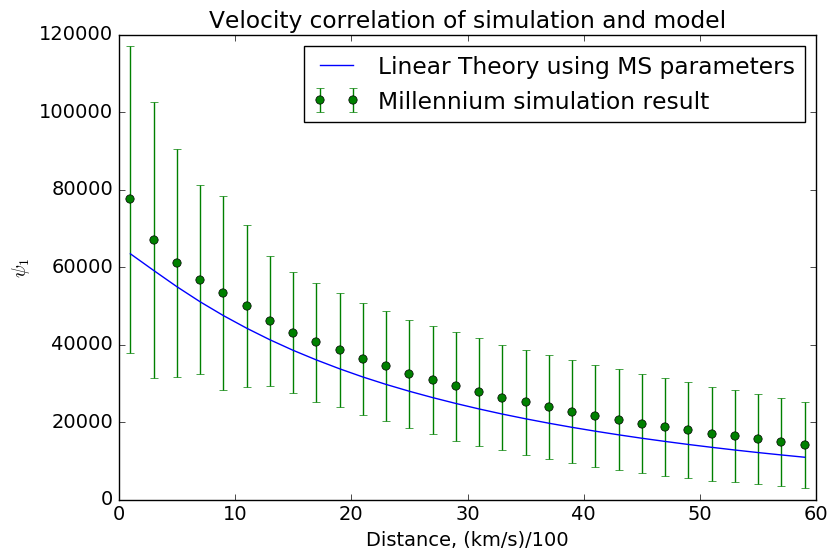

In [12]:
def cvcompare():
    millparams = {'gamma': 0.73*0.25,
                  'beta' : 0.9*.25**.55} # 0.9
    data = np.load('/home/christopher/code/Physics/millennium/matplot/output/CF3-group-60-cv-bin-2-Mpchnice.npy')
    xs = data[0]
    psi1 = data[1]
    sig_psi1 = data[2]
    modelplot(xs,millparams['gamma'],millparams['beta'],(0.9)**2 / sigrsqr(8,millparams['gamma']),data[5],psi1,sig_psi1)
    print((0.9)**2 / sigrsqr(8,millparams['gamma']))
cvcompare()
#A*1.65
with pdfback.PdfPages("ModelSimulationDistance".format(SURVEY,BIN_SIZE_MPC,numbins*BIN_SIZE_MPC)) as pdf:
    pdf.savefig()

Note that there's a systematic difference between the velocity correlation of the millennium simulation and the linear theory result predicted using the millennium simulation parameters. We should probably figure out why this happens, but I don't have the knowledge available to debug this. It might help if Yuyu calculated this as well...

Chi^2 = 1.5803
3003256.3243695945


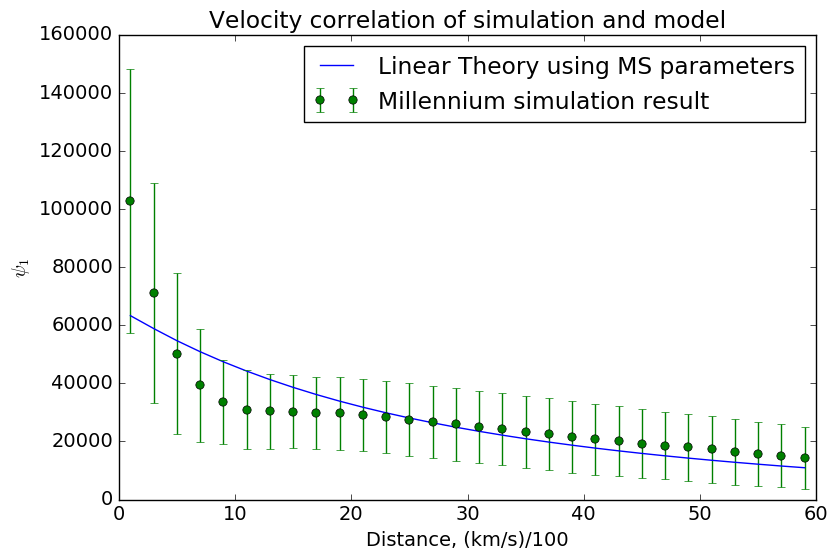

In [13]:
def cvcompare():
    millparams = {'gamma': 0.73*0.25,
                  'beta' : 0.9*.25**.55} # 0.9
    data = np.load('/home/christopher/code/Physics/millennium/matplot/output/CF3-group-60-cv-bin-200-kmsnice.npy')
    xs = data[0]
    psi1 = data[1]
    sig_psi1 = data[2]
    modelplot(xs,millparams['gamma'],millparams['beta'],(0.9)**2 / sigrsqr(8,millparams['gamma']),data[5],psi1,sig_psi1,xscale=100)
    print((0.9)**2 / sigrsqr(8,millparams['gamma']))
cvcompare()
#A*1.65
with pdfback.PdfPages("ModelSimulationRedshift".format(SURVEY,BIN_SIZE_MPC,numbins*BIN_SIZE_MPC)) as pdf:
    pdf.savefig()

This is more likely the plot that we will get from the real data, since we're using redshift-as-distance. Notice how there is NO SIMILARITY. What's the linear theory for redshift-space velocity correlation?! Maybe Feldman and Watkins should derive *THAT*.

### Set Plot Bounds Here!

In [14]:
min_gamma = 0.05
max_gamma = 0.6
min_beta = 0.2
max_beta = 1
d_gamma = 0.005#0.007
d_beta = 0.005#0.02


def run_integrals(gamma,xs):
    prpintegral = []
    parintegral = []
    for x in xs:
        oneintegral = integrate.quad(integrandperp2,0,10,args=(gamma,x),limit=500)[0]
        oneparintegral = integrate.quad(integrandpar2,0,10,args=(gamma,x),limit=500)[0]
        prpintegral.append(oneintegral)
        parintegral.append(oneparintegral)
    oneintegral = np.array(prpintegral)
    oneparintegral = np.array(parintegral)
    return (oneintegral,oneparintegral)

### Chi Squared Analysis
Now we're ready to run the analysis. This computes the value of the $\chi^2$ of the fit over a range of Gamma and Beta values. The `chi_sq` function calculates all the beta values for one gamma value, and it can be run in parallel.

In [15]:
gammarange = np.arange(min_gamma,max_gamma,d_gamma)
betarange = np.arange(min_beta,max_beta,d_beta)
outmatrix = "haha"

def fitting_fun(x,gamma,beta):
    pass #?
def single_chi_sq(atuple):
    gamma,beta,A,a,psi1realdata= atuple
    oneintegral,oneparintegral = run_integrals(gamma)
    psiperps = A*(beta)**2 * oneintegral * 10000/(2*np.pi**2)
    psipars = A*(beta)**2 * oneparintegral * 10000/(2*np.pi**2)
    p1 = a*psipars + (1-a)*psiperps
    return sum((data[1]-p1)**2/p1**2)

def chi_sq(atuple):
    gamma,listofbeta,A,a,xs,psi1realdata,junk = atuple #WARNING! THIS IS A KLUDGE!
    listout = np.zeros((len(listofbeta)))
    oneintegral, oneparintegral = run_integrals(gamma,xs)
    for i,beta in enumerate(listofbeta):
        psiperps = A*(beta)**2 * oneintegral * 10000/(2*np.pi**2)
        psipars = A*(beta)**2 * oneparintegral * 10000/(2*np.pi**2)
        p1 = a*psipars + (1-a)*psiperps
        listout[i] = sum((psi1realdata-p1)**2/p1**2)
    return listout

def chi_sq2(atuple):
    gamma,listofbeta,A,a,xs,psi1realdata,weights = atuple
    listout = np.zeros((len(listofbeta)))
    oneintegral, oneparintegral = run_integrals(gamma,xs)
    for i,beta in enumerate(listofbeta):
        psiperps = A*(beta)**2 * oneintegral * 10000/(2*np.pi**2)
        psipars = A*(beta)**2 * oneparintegral * 10000/(2*np.pi**2)
        p1 = a*psipars + (1-a)*psiperps
        listout[i] = sum((psi1realdata-p1)**2/weights**2)
    return listout


def millenniumChi2mpc():
    millparams = {'gamma': 0.73*0.25,
                  'beta' : 0.9*.25**.55} # 0.9
    data = np.load('/home/christopher/code/Physics/millennium/matplot/output/CF3-group-60-cv-bin-2-Mpchnice.npy')
    xs = data[0]#/100
    psi1 = data[1]
    sig_psi1 = data[2]
    a = data[5]
    tuples = [(x,y,(0.9)**2 / sigrsqr(8,millparams['gamma']),a,xs,psi1,sig_psi1) for x,y in zip(list(gammarange),
                                                 itertools.repeat(betarange))]
    outmatrix = np.array(list(poolMap(chi_sq,tuples)))
    outmatrix2 =np.array(list(poolMap(chi_sq2,tuples)))
    return (outmatrix,outmatrix2)

def millenniumChi2kms():
    millparams = {'gamma': 0.73*0.25,
                  'beta' : 0.9*.25**.55} # 0.9
    data = np.load('/home/christopher/code/Physics/millennium/matplot/output/CF3-group-60-cv-bin-200-kmsnice.npy')
    xs = data[0]/100
    psi1 = data[1]
    sig_psi1 = data[2]
    a = data[5]
    tuples = [(x,y,(0.9)**2 / sigrsqr(8,millparams['gamma']),a,xs,psi1,sig_psi1) for x,y in zip(list(gammarange),
                                                 itertools.repeat(betarange))]
    outmatrix = np.array(list(poolMap(chi_sq,tuples)))
    outmatrix2 =np.array(list(poolMap(chi_sq2,tuples)))
    return (outmatrix,outmatrix2)

In [16]:
#print(single_chi_sq((0.51,2)))
#print(chi_sq((0.51,[2])))
#minrbt=minimize(single_chi_sq,x0=[0.5,0.5],bounds=[(0.001,1),(0.001,2)])
#mingamma = minrbt.x[0]
#minbeta = minrbt.x[1]

The Chi Squared analysis ~~takes a lot of time, so I've hidden it from running every time you boot up the notebook and click "Kernel Restart and Run All". Instead, use the buttons above. The function saves its output, so if there's already an output file you can load it using "get existing data."~~ takes no time at all so don't worry about it.

### Results!
Now we can see the results! The plot displays the $\chi^2$ values for each combination of gamma and beta. The contours highlight minimum regions. Gamma is somewhere between 0.2 and 0.3 and Beta is somewhere between 0.45 and 0.7. In the Watkins paper they were able to assign a likelyhood value to each contour. It would be nice to do that as well. This is chi_squared per degree of freedom so that I can compare my data which uses a bin size of 2 with Yuyu's which usually uses 5.

In [17]:
outmatrix,outmatrix2=millenniumChi2mpc()
outmatrix3,outmatrix4 = millenniumChi2kms()

Could not restart pool. New pool?


0.02282922152
60
2.83631233118


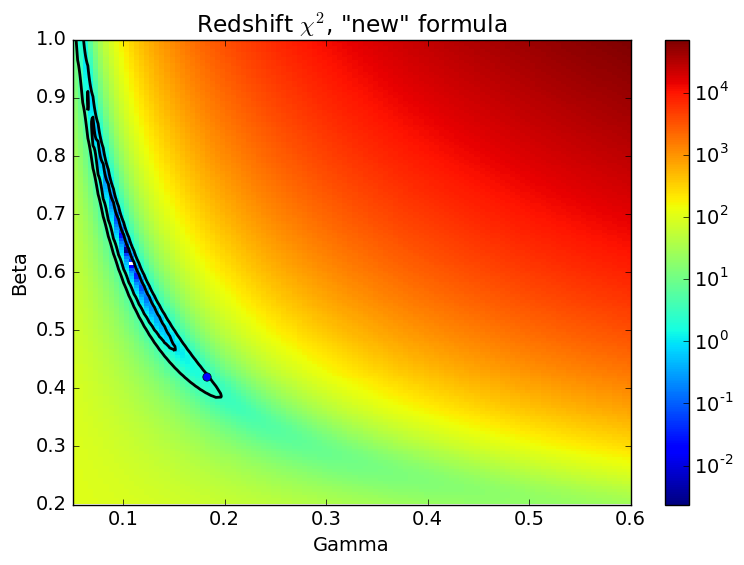

In [18]:
print(np.min(outmatrix))
print(numbins)
extenttuple = (min_gamma,max_gamma,min_beta,max_beta)
tempoutmatrix = outmatrix4#/numbins#*BIN_SIZE_MPC/50
print(np.min(tempoutmatrix))
newoutm = (tempoutmatrix - np.min(tempoutmatrix))# + 10000
imshow(newoutm.T,
       interpolation='nearest',
       origin='lower',
       norm=LogNorm(),
       extent=extenttuple,
       aspect="auto"
    )
colorbar()
CS = contour(newoutm.T,
             [1,3],
             colors='k',
             linewidths=2,
             extent=extenttuple
            )
#clabel(CS,inline=1)

plot(0.73*0.25,0.9*.25**.55,'o')
ylabel("Beta")
xlabel("Gamma")
title("Redshift $\chi^2$, \"new\" formula".format(SURVEY[0:-3],BIN_SIZE_MPC*100,numbins*BIN_SIZE_MPC*100))
with pdfback.PdfPages("redshiftenew".format(SURVEY,BIN_SIZE_MPC,numbins*BIN_SIZE_MPC)) as pdf:
    pdf.savefig()
    
#Send feldman contour plots and linear theory scatter plot

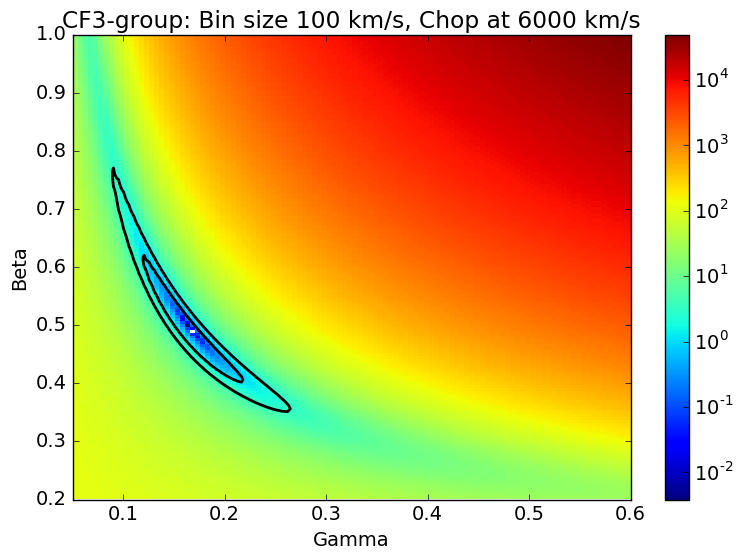

In [19]:
tempoutmatrix = outmatrix2#/numbins#*BIN_SIZE_MPC/50
newoutm = (tempoutmatrix - np.min(tempoutmatrix))# + 10000
imshow(newoutm.T,
       interpolation='nearest',
       origin='lower',
       norm=LogNorm(),
       extent=extenttuple,
       aspect="auto"
    )
colorbar()
CS = contour(newoutm.T,
             [1,3],
             colors='k',
             linewidths=2,
             extent=extenttuple
            )
#clabel(CS,inline=1)
ylabel("Beta")
xlabel("Gamma")
title("{}: Bin size {:.0f} km/s, Chop at {:.0f} km/s".format(SURVEY[0:-3],BIN_SIZE_MPC*100,numbins*BIN_SIZE_MPC*100))
with pdfback.PdfPages("contour-{}-BIN{}-CHOP{}".format(SURVEY,BIN_SIZE_MPC,numbins*BIN_SIZE_MPC)) as pdf:
    pdf.savefig()

In [20]:
#Use PLANCK beta to calculate likelyhood!
#beta = f(omegam)sigma8
beta = (0.313**.55)*.829
print(beta)
tuples = [(x,y) for x,y in zip(list(gammarange),
                               itertools.repeat([beta]))]
chi2 = np.array(list(poolMap(chi_sq,tuples)))

likelyhood = np.exp(-chi2)
plot(gammarange,likelyhood)
xlabel("$\Gamma$")
ylabel("Likelyhood")
title("{}: Bin size {:.0f} km/s, Chop at {:.0f} km/s\nUsing Planck Beta value.".format(SURVEY[0:-3],BIN_SIZE_MPC*100,numbins*BIN_SIZE_MPC*100))
#WMAP beta = .41
with pdfback.PdfPages("useplanck-{}-BIN{}-CHOP{}".format(SURVEY,BIN_SIZE_MPC,numbins*BIN_SIZE_MPC)) as pdf:
    pdf.savefig()

0.4376268061772306


ValueError: need more than 2 values to unpack

In [ ]:
#Try to marginalize over beta
likelyhood = np.exp(-outmatrix)
plot(gammarange,np.sum(likelyhood,axis=1))
print(outmatrix.shape)
print(len(gammarange))
xlabel("$\Gamma$")
ylabel("Sum of all likelyhoods")
title("{}: Bin size {:.0f} km/s, Chop at {:.0f} km/s\nMarginalizing over all beta.".format(SURVEY[0:-3],BIN_SIZE_MPC*100,numbins*BIN_SIZE_MPC*100))
with pdfback.PdfPages("marginalize-{}-BIN{}-CHOP{}".format(SURVEY,BIN_SIZE_MPC,numbins*BIN_SIZE_MPC)) as pdf:
    pdf.savefig()

Now we calculate the matrix $C^{ij}$ using the "all" data file from CF3-gal (the simulation). That's the covariance matrix for the correlation function. I'm not totally sure what it means, but I definitely know how to calculate it. Here goes:
$$C^{ij} = \frac{1}{N_{mock}} \sum_{l=1}^{N_{mock}}\left(\psi_1^l(i) - \bar{\psi}_1(i)\right)\left(\psi_1^l(j) - \bar{\psi}_1(j)\right)$$

That equation uses Einstein summation notation to build the matrix $C^{ij}$. The $i$ and $j$ are the same on the left and the right.

In [ ]:

#def singlecij(onesurvey,means):
#    psi1 = onesurvey[0]
#    right = np.array([psi1 - means])
#    left = right.T
#    #print(left.shape, right.shape)
#    return left * right
   

#cijinnards = [singlecij(a,b) for a,b in zip(datall, itertools.repeat(datacv[1]))]
#cij1 = (1/100) * np.sum(np.array(cijinnards),axis=0)
#cijinv1 = numpy.linalg.inv(cij1)


select = np.logical_and(np.arange(0,100,1) != 75,np.arange(0,100,1) != 11)
#select = np.logical_or(select <50, select > 55)
delta21 = datall[select,0,:]/10000 - datacv[1]/10000
print(len(delta21))
cij= np.dot(delta21.T,delta21)/len(delta21)
cijinv = np.linalg.inv(cij)

#imshow(cij2inv,interpolation='nearest',norm=LogNorm(),cmap='jet',origin='lower')
imshow(cijinv,interpolation="nearest")#,norm=LogNorm())
colorbar()

#The 21 is a random number to make sure there's nothing else called delta


#cijplot = np.zeros(cij.shape)
#for i in range(cij.shape[0]):
#    for j in range(cij.shape[0]):
#        cijplot[i][j] = cij[i][j]/(datacv[1][i]*datacv[1][j])
#indices = range(cij.shape[0])
#plot(indices,[cijplot[9][x] for x in indices])
#ylim((0,1))

In [ ]:
datally = np.load(head+'{}-yuyu-cv-bin-{}-kmsall.npy'.format(SURVEY,BIN_SIZE_KM))
datacvy = np.load(head+'{}-yuyu-cv-bin-{}-kmsnice.npy'.format(SURVEY,BIN_SIZE_KM))
delta21y = datally[select,0,:]/10000 - datacvy[1]/10000
print(len(delta21y))
cij2y= np.dot(delta21y.T,delta21y)/100
cij2invy = np.linalg.inv(cij2y)
imshow(1/(cijinv/cij2invy),interpolation="nearest")#,norm=LogNorm())
colorbar()
#cijinv = cij2invy
raise RuntimeError("NONE SHALL PASS")

Now we need to do something with the $C^{ij}$ matrix - get the weighted chi squared values instead of raw ones. Till Tomorrow! IT IS TOMORROW NOW! LOOK OUT WORLD! *sigh*

In [ ]:
#dot(cij,cijinv) #should be identity matrix It is!
gammarange = np.arange(min_gamma,max_gamma,d_gamma)
betarange = np.arange(min_beta,max_beta,d_beta)
wtoutmatrix = "haha"
def chi_sq_wt(atuple):
    gamma,listofbeta = atuple
    listout = np.zeros((len(listofbeta)))
    oneintegral, oneparintegral = run_integrals(gamma)
    for i,beta in enumerate(listofbeta):
        psiperps = A*(beta)**2 * oneintegral * 10000/(2*np.pi**2)
        psipars = A*(beta)**2 * oneparintegral * 10000/(2*np.pi**2)
        p1 = a*psipars + (1-a)*psiperps
        
        deltapsi = np.array([data[1]-p1])
        elem = np.dot(np.dot(deltapsi,cijinv),deltapsi.T)
        #inefficientlist = []
        #for i2 in range(len(p1)):
        #    for j2 in range(len(p1)):
        #        deltai = data[1][i2] - p1[i2]
        #        deltaj = data[1][j2] - p1[j2]
        #        value = deltai*cijinv[i2][j2]*deltaj
        #        
        #        print("{:2} {:2}: {:12.3e}   {:12.3e}   {:12.3e}   {:12.3e}".format(i2,j2,deltai,cijinv[i2][j2],deltaj,value))
        #        inefficientlist.append(value)
        #elem = sum(inefficientlist)
        ##assert(abs(elem1-elem) < 1)
        listout[i] = elem
    return listout

tuples = [(x,y) for x,y in zip(list(gammarange),
                               itertools.repeat(betarange))]

wtoutmatrix = np.array(list(poolMap(chi_sq_wt,tuples)))


In [ ]:
chi_sq_wt((0.0524,[3.19]))

In [ ]:
print(np.min(wtoutmatrix))
print(wtoutmatrix.shape)
extenttuple = (min_gamma,max_gamma,min_beta,max_beta)
wtnewoutm = (wtoutmatrix - np.min(wtoutmatrix))#*BIN_SIZE_MPC/50# + 10000
imshow(wtnewoutm.T,
       interpolation='nearest',
       origin='lower',
       norm=LogNorm(),
       extent=extenttuple,
       aspect="auto"
    )
colorbar()
CS = contour(wtnewoutm.T,
             [2.3,6.2],
             colors='k',
             linewidths=2,
             extent=extenttuple
            )
#clabel(CS,inline=1)
ylabel("Beta")
xlabel("Gamma")
with pdfback.PdfPages("wtchisqmatrix-{}-BIN{}".format(min_beta,max_beta,min_gamma,max_gamma,BIN_SIZE_MPC)) as pdf:
    pdf.savefig()

In [ ]:
p1 = [ 1133.76646488,  1116.26634822,  1096.54003894,  1075.91717229,  1054.89306645,
  1034.49039199,  1013.20133933,   992.09224686,   971.05961735,   950.13004444,
   929.84729259,   910.08399065,   890.24115106,   870.47380777,   851.80138883,
   833.59824726,   815.86558915,   798.9505263,    782.51105062,   766.70505845,
   751.73922197,   736.99669873,   721.41147602,   705.54518436,   689.62135247]
data[1]
deltas = data[1]-p1
thesum = 0

inefficientlist = []
for i2 in range(len(p1)):
    for j2 in range(len(p1)):
        delta = data[1][i2] - p1[i2]
        inefficientlist.append(delta*cijinv[i2][j2]*delta)
print(inefficientlist[0])
for i in range(len(deltas)):
    for j in range(len(deltas)):
        thesum += deltas[i]*deltas[i]*cijinv[i][j]
        print(thesum)
        
deltapsi = np.array([data[1]-p1])
elem1 = np.dot(np.dot(deltapsi,cijinv),deltapsi.T)
elem2 = np.dot(deltapsi,np.dot(cijinv,deltapsi.T))
print(elem2)
print(elem1)
print(thesum)

Just testing, don't mind me... NO! *DO* mind me! I've ruined everything!!!

In [ ]:
a1 = np.array([[5,10],[10,30]])
b1 = np.array([3,2])
c1 = np.array([[3],[2]])
np.dot(a1,b1)
#NOT THIS AGAIN

In [ ]:
a1 = np.array([1,2,3,4,5])
b1 = np.vstack((a1,a1))
b1 - a1

In [ ]:
c2 = np.random.normal(5,1,(5,5))

In [ ]:
a2 = np.array([1,2,3,4,5])
a3 = a2.reshape(1,5)

result1 = np.inner(np.dot(c2,a2),a2)
result2 = np.dot(np.dot(a3,c2),a3.T)
print(result1,result2)